In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('Hotel_Reviews.csv')

In [3]:
# We will compute the ratio of Positive to Negative reviews forall hotels and its evolution over time.
# For instance, Positive/Negative ratio of 2 means that the hotel got 2 times more positive reviews than negative reviews

In [4]:
df['Negative_Review']=[x.lower().strip() for x in df['Negative_Review']]
df['Positive_Review']=[x.lower().strip() for x in df['Positive_Review']]

In [5]:
# In the daaset, see can see that most of the short negative reviews are in fact 'no negative' reviews

In [6]:
short_negative_reviews=df[['Negative_Review','Review_Total_Negative_Word_Counts']][df['Review_Total_Negative_Word_Counts']<=3]
short_negative_reviews=short_negative_reviews.groupby(['Negative_Review']).size()
short_negative_reviews=short_negative_reviews/short_negative_reviews.sum()
short_negative_reviews=short_negative_reviews.sort_values(ascending=False)
short_negative_reviews.name='proportion'
short_negative_reviews.head(10)

Negative_Review
no negative    0.749293
nothing        0.124120
n a            0.010400
none           0.008794
               0.004974
breakfast      0.003193
location       0.002941
small room     0.002818
everything     0.002461
all good       0.002256
Name: proportion, dtype: float64

In [7]:
# No negative (0.75), nothing (0.12) and others with a word count of <=3 make up more than 90% of negative reviews,
# And hence not a Negative review, hence a word count more than 3 will be considered as a Negative review. 

In [8]:
# Now similiarly for positive reviews
short_positive_reviews=df[['Positive_Review','Review_Total_Positive_Word_Counts']][df['Review_Total_Positive_Word_Counts']<=3]
short_positive_reviews=short_positive_reviews.groupby(['Positive_Review']).size()
short_positive_reviews=short_positive_reviews/short_positive_reviews.sum()
short_positive_reviews=short_positive_reviews.sort_values(ascending=False)
short_positive_reviews.name='proportion'
short_positive_reviews.head(10)

Positive_Review
no positive       0.452646
location          0.150416
everything        0.041731
nothing           0.021797
the location      0.017176
great location    0.016018
good location     0.015048
breakfast         0.010011
friendly staff    0.007984
staff             0.006964
Name: proportion, dtype: float64

In [9]:
df['Negative']=df['Review_Total_Negative_Word_Counts'].apply(lambda x: 1 if x>=3 else 0)
df['Positive']=df['Positive_Review'].apply(lambda x: 0 if x in ['no positive', 'nothing', 'na', 'n a'] else 1)

In [10]:
hotels=df[['Hotel_Address','Hotel_Name','Review_Date','Average_Score','Reviewer_Score','Total_Number_of_Reviews','Negative','Positive']]

In [11]:
# For simplification, lets create an ID for each Hotel
unique_hotels=hotels.groupby(['Hotel_Address','Hotel_Name'],as_index=False).size().reset_index().drop(0, 1)
unique_hotels['Hotel_Id']=range(len(unique_hotels))
hotels=hotels.merge(unique_hotels,how='left',on=['Hotel_Address','Hotel_Name'])
hotels['Review_Date']=pd.to_datetime(hotels['Review_Date'])

In [12]:
# Now compute the ratio

In [13]:
hotels['Daily_Positive']=hotels.groupby(['Hotel_Id','Review_Date'])['Positive'].cumsum()
hotels['Daily_Negative']=hotels.groupby(['Hotel_Id','Review_Date'])['Negative'].cumsum()
review_balance=hotels[['Hotel_Id','Review_Date','Daily_Positive','Daily_Negative']].groupby(['Hotel_Id','Review_Date']).aggregate(max).reset_index()
review_balance['Daily_Positive_Cumsum']=review_balance.groupby(['Hotel_Id'])['Daily_Positive'].cumsum()
review_balance['Daily_Negative_Cumsum']=review_balance.groupby(['Hotel_Id'])['Daily_Negative'].cumsum()
review_balance['Total_Reviews']=review_balance['Daily_Positive_Cumsum']+review_balance['Daily_Negative_Cumsum']
review_balance['Ratio_Balance']=review_balance['Daily_Positive_Cumsum']/(1+review_balance['Daily_Negative_Cumsum'])

In [14]:
# When rating an hotel, other factors might influence the reviewer and tends to give a score not too far from the average 
# But, Positive and negative reviews requires a personal description as an example, so the reviewer might be less influenced here
# Hence, we use the Positive-Negative ratio as a measure of the quality of the hotel

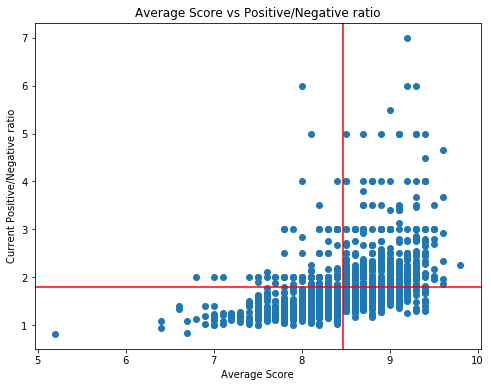

In [15]:
ratings=hotels[['Hotel_Id','Average_Score']].groupby('Hotel_Id').aggregate(max).reset_index().merge(review_balance[['Hotel_Id','Ratio_Balance']].groupby('Hotel_Id').aggregate(max).reset_index(),on='Hotel_Id',how='inner')
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(ratings['Average_Score'],ratings['Ratio_Balance'])
ax.set_title('Average Score vs Positive/Negative ratio')
ax.set_xlabel("Average Score")
ax.set_ylabel("Current Positive/Negative ratio")
plt.axhline(y=ratings['Ratio_Balance'].mean(),color='r',label='average trend')
plt.axvline(x=ratings['Average_Score'].mean(),color='r',label='mean ratio')
plt.show()

In [16]:
# The red lines are the average score (vertical) and average Positive/Negative ratio (horizontal)

In [17]:
from sklearn import linear_model
start=min(hotels['Review_Date'])
stop=max(hotels['Review_Date'])

In [18]:
review_balance['Days_Ellapsed']=[x/np.timedelta64(1, 'D') for x in (review_balance['Review_Date'] -  start)]
max_days_ellapsed=max(review_balance['Days_Ellapsed'])
review_balance['Days_Ellapsed']=review_balance['Days_Ellapsed'].apply(int)/max_days_ellapsed
review_balance['Trend']=0
# The number of days elased since the review will be used as a time scale

In [21]:
import warnings
warnings.simplefilter('ignore')

grouped=review_balance.groupby('Hotel_Id',as_index=False)
trends={'Hotel_Id':[],'Trend':[],'Total_Reviews':[],'Current_Ratio':[]}

In [23]:
# for Trendestimation, we analyse the trend with a sufficient amount of reviews, here 100
for name, group in grouped:
    group=group[group['Total_Reviews']>=100]
    group['Trend']=0
    try:
        assert(len(group)>0)
    except AssertionError:
        pass
    else:
        regr = linear_model.LinearRegression()
        X=np.array(group['Days_Ellapsed']).reshape(-1, 1)
        y=np.array(group['Ratio_Balance'])
        regr.fit(X,y )
        trends['Hotel_Id'].append(name)
        trends['Trend'].append(regr.coef_[0])
        trends['Total_Reviews'].append(max(group['Total_Reviews']))
        trends['Current_Ratio'].append(max(group['Ratio_Balance']))

trends=pd.DataFrame(trends)

In [25]:
# To keep thevisuals unbaised, lets keep the hotels with consistency (with most reviews)
# Hence computed the trend based on the reviews>100
# We will consider that the trend is correctly computed if there is at least 100 reviews more to compute it.
# y=the hotels with 200 reviews at least

trends=trends[trends['Total_Reviews']>=200]

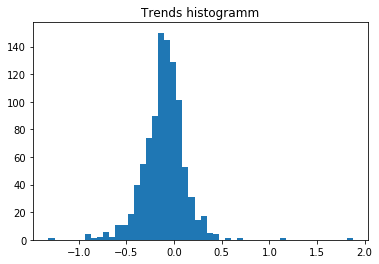

In [26]:
fig=plt.figure(1)
plt.hist(trends['Trend'],bins=50)  
plt.title('Trends histogramm')
plt.show()
# Distribution of the trends

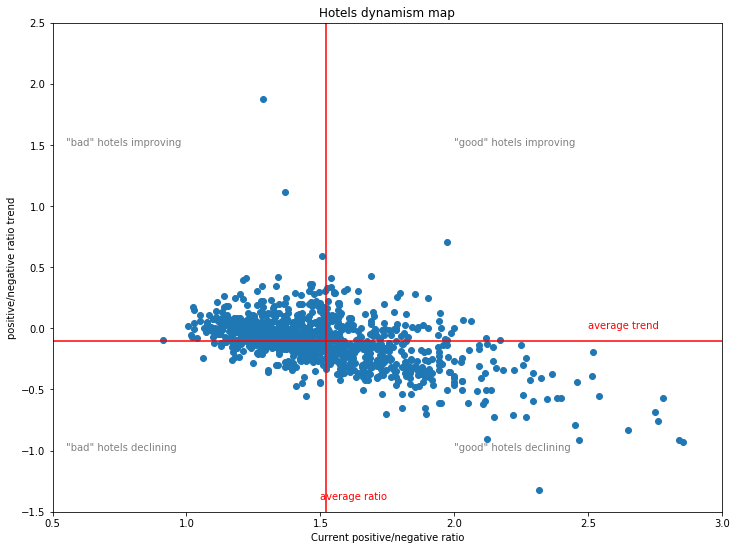

In [28]:
# Now, to visualise the evolution of the quality of an hotel, based on the positive/negative ratio and the trend
m1=trends['Trend'].mean()
m2=trends['Current_Ratio'].mean()

fig, ax = plt.subplots(figsize=(12, 9))
ax.scatter(trends['Current_Ratio'],trends['Trend'])
ax.set_title("Hotels dynamism map")
ax.set_xlabel("Current positive/negative ratio")
ax.set_ylabel("positive/negative ratio trend")
ax.set_xlim(0.5,3)
ax.set_ylim(-1.5,2.5)
ax.annotate('"good" hotels improving',xy=(2,1.5),xytext=(2,1.5),color='grey')
ax.annotate('"good" hotels declining',xy=(2,-1),xytext=(2,-1),color='grey')
ax.annotate('"bad" hotels improving',xy=(0.6,1.5),xytext=(0.55,1.5),color='grey')
ax.annotate('"bad" hotels declining',xy=(0.6,-1),xytext=(0.55,-1),color='grey')
plt.axhline(y=m1,color='r',label='average trend')
plt.axvline(x=m2,color='r',label='average ratio')
ax.annotate('average trend',xy=(2.5,0),xytext=(2.5,0),color='red')
ax.annotate('average ratio',xy=(1.5,-1.4),xytext=(1.5,-1.4),color='red')
plt.show()

In [29]:
# The above measure implies that, in average, "bad" hotels tend to improve more than "good" ones.

In [32]:
# Now, the top 20 improving hotels according to the Positive/Negative ratio evolution
tops=hotels[['Hotel_Id','Average_Score','Hotel_Name','Hotel_Address','Total_Number_of_Reviews']].groupby('Hotel_Id').first().reset_index().merge(trends[['Hotel_Id','Trend']],on='Hotel_Id',how='inner')[['Hotel_Id','Hotel_Name','Hotel_Address','Trend','Average_Score','Total_Number_of_Reviews']].sort_values(by='Trend',ascending=False)
tops.head(20)

,Hotel_Id,Hotel_Name,Hotel_Address,Trend,Average_Score,Total_Number_of_Reviews
768,1202,The Ned,Poultry 27 City of London London EC2R 8AJ Unit...,1.875818,9.3,517
520,881,Chasse Hotel,Chassestraat 62 64 De Baarsjes 1057 JJ Amsterd...,1.116256,8.9,404
94,162,Mill sime H tel,15 Rue Jacob 6th arr 75006 Paris France,0.704008,9.3,656
675,1083,Room Mate Carla,Mallorca 288 Eixample 08037 Barcelona Spain,0.590149,8.9,1257
364,626,Le Burgundy Paris,6 8 Rue Duphot 1st arr 75001 Paris France,0.430241,9.1,683
407,706,Les Jardins Du Marais,74 rue Amelot 11th arr 75011 Paris France,0.416794,8.1,838
812,1259,Hotel Lam e,Rotenturmstra e 15 01 Innere Stadt 1010 Vienna...,0.411465,8.7,866
366,632,Park Plaza London Waterloo,6 Hercules Road Lambeth London SE1 7DP United ...,0.410252,8.8,1489
908,1391,Leonardo Hotel Milan City Center,Via Messina 10 Sempione 20154 Milan Italy,0.393084,8.2,1018
487,838,Hotel Barcelona Universal,Avinguda Paral lel 76 78 Ciutat Vella 08001 Ba...,0.359169,8.8,807


In [33]:
# The top 20 decreasing
tops.tail(20)

,Hotel_Id,Hotel_Name,Hotel_Address,Trend,Average_Score,Total_Number_of_Reviews
707,1124,Ham Yard Hotel,One Ham Yard Westminster Borough London W1D 7D...,-0.608795,9.5,314
775,1209,Andaz Amsterdam Prinsengracht A Hyatt Hotel,Prinsengracht 587 Amsterdam City Center 1067 H...,-0.611755,9.3,851
118,208,Malmaison London,18 21 Charterhouse Square Islington London EC1...,-0.612784,8.7,1374
374,649,The Chess Hotel,6 rue du Helder 9th arr 75009 Paris France,-0.614607,8.7,1005
205,359,Draycott Hotel,26 Cadogan Gardens Kensington and Chelsea Lond...,-0.652141,9.2,245
356,614,The Sumner Hotel,54 Upper Berkeley Street Westminster Borough L...,-0.655304,8.5,762
730,1150,Hotel The Serras,Passeig de Colom 9 Ciutat Vella 08002 Barcelon...,-0.680443,9.6,604
38,64,Amp re,102 Avenue de Villiers 17th arr 75017 Paris Fr...,-0.698839,8.8,998
802,1246,Roger de Ll ria,Roger de Lluria 28 Eixample 08010 Barcelona Spain,-0.702908,8.5,596
23,34,The Nadler Soho,10 Carlisle Street Westminster Borough London ...,-0.709469,9.0,1394


In [40]:
df.to_csv('tops.csv',index=False)